In [6]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import pandas as pd

In [8]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [10]:
# Create engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [11]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables
Base.prepare(engine, reflect=True)

In [12]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [14]:
# Create our session from Python to the DB
session = Session(engine)

# Inspection

In [15]:
#Inspect engine and get table names
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [16]:
# Using the inspector to print the column names within the 'measurements' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [17]:
# Using the inspector to print the column names within the 'measurements' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [18]:
# Define a vacation date
start_vacation = dt.date(2017, 3, 1)
end_vacation = dt.date(2017, 3, 15)
print(f'Start: {start_vacation} | End: {end_vacation}')

Start: 2017-03-01 | End: 2017-03-15


### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [19]:
# Calculate the date 1 year ago from the last data point in the database
datepoint = session.query(func.max(Measurement.date)).\
    select_from(Measurement).\
    order_by(Measurement.date).all()
datepoint = datepoint[0][0]
last_datepoint = dt.datetime.strptime(datepoint, '%Y-%m-%d').date()
one_year_ago = last_datepoint.replace(year=last_datepoint.year-1)
print(f'The last datepoint is {last_datepoint} and 12M ago from it is {one_year_ago}')

The last datepoint is 2017-08-23 and 12M ago from it is 2016-08-23


In [20]:
# Perform a query to retrieve the data and precipitation scores
precipitation_scores = session.query(Station.name, Measurement.date, Measurement.prcp
    ).filter(Measurement.date >= one_year_ago
    ).filter(Measurement.station == Station.station
    ).all()

In [21]:
results = session.query(Station.id, Station.name).all()
print(results)

[(1, 'WAIKIKI 717.2, HI US'), (2, 'KANEOHE 838.1, HI US'), (3, 'KUALOA RANCH HEADQUARTERS 886.9, HI US'), (4, 'PEARL CITY, HI US'), (5, 'UPPER WAHIAWA 874.3, HI US'), (6, 'WAIMANALO EXPERIMENTAL FARM, HI US'), (7, 'WAIHEE 837.5, HI US'), (8, 'HONOLULU OBSERVATORY 702.2, HI US'), (9, 'MANOA LYON ARBO 785.2, HI US')]


In [22]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_scores, columns=['station_name', 'date', 'prcp'])
precipitation_df.head()

,station_name,date,prcp
0,"WAIKIKI 717.2, HI US",2016-08-23,0.00
1,"WAIKIKI 717.2, HI US",2016-08-24,0.08
2,"WAIKIKI 717.2, HI US",2016-08-25,0.08
3,"WAIKIKI 717.2, HI US",2016-08-26,0.00
4,"WAIKIKI 717.2, HI US",2016-08-27,0.00


In [23]:
# Sort the dataframe by date
precipitation_df.sort_values(by=['date'], inplace=True)

In [24]:
# Pivot information to facilitate ploting
precipitation_df_pvt = precipitation_df.pivot(index='date', columns='station_name', values='prcp')

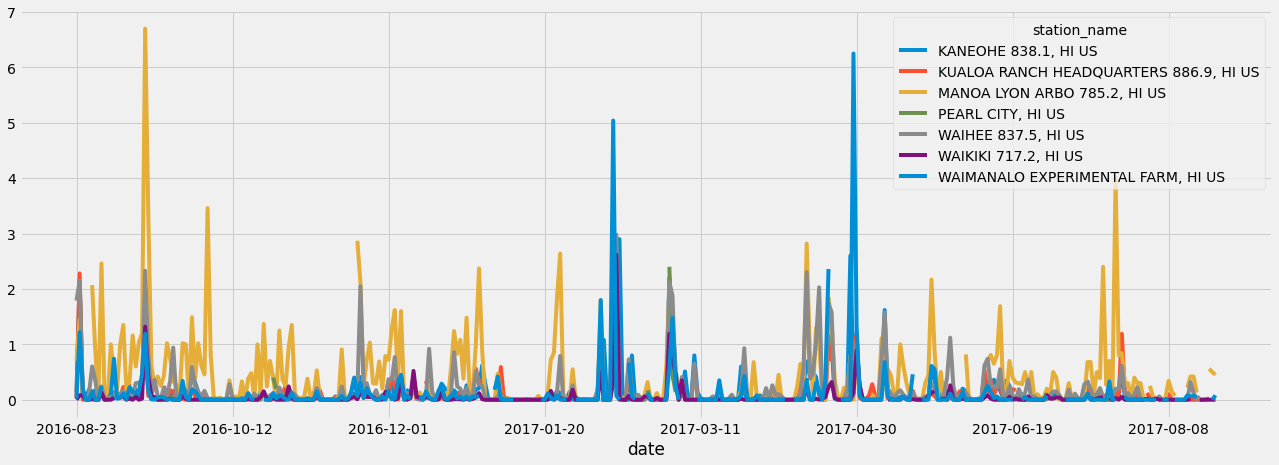

In [25]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df_pvt.plot(figsize=(20,7))
plt.show()

In [26]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df_pvt.describe()

station_name,"KANEOHE 838.1, HI US","KUALOA RANCH HEADQUARTERS 886.9, HI US","MANOA LYON ARBO 785.2, HI US","PEARL CITY, HI US","WAIHEE 837.5, HI US","WAIKIKI 717.2, HI US","WAIMANALO EXPERIMENTAL FARM, HI US"
count,343.000000,265.000000,328.000000,60.000000,352.000000,359.000000,314.000000
mean,0.141429,0.125434,0.450640,0.076500,0.198949,0.044819,0.121051
std,0.341245,0.316290,0.717174,0.317857,0.419182,0.188810,0.509002
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000
50%,0.030000,0.020000,0.190000,0.000000,0.060000,0.000000,0.000000
75%,0.120000,0.120000,0.610000,0.025000,0.190000,0.020000,0.060000
max,2.900000,2.390000,6.700000,2.400000,2.980000,2.620000,6.250000


In [27]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.name).distinct().count()

9

In [28]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, Station.name, func.count(Measurement.prcp)).\
    group_by(Station.name).\
    filter(Measurement.station == Station.station).\
    order_by(func.count(Measurement.prcp).desc()).all()

In [29]:
# Store it to a Data Frame for better visualization
active_stations_df = pd.DataFrame(active_stations, columns=['station_id', 'station_name', 'measure_counts'])
active_stations_df

,station_id,station_name,measure_counts
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00513117,"KANEOHE 838.1, HI US",2696
2,USC00519397,"WAIKIKI 717.2, HI US",2685
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2572
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2484
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1937
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1932
7,USC00517948,"PEARL CITY, HI US",683
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",342


In [30]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
min_max_avg_temp = session.query(
    Measurement.station, 
    Station.name, 
    func.min(Measurement.tobs),
    func.round(func.avg(Measurement.tobs)),
    func.max(Measurement.tobs)    
    ).\
        group_by(Station.name).\
        filter(Measurement.station == Station.station).all()

In [31]:
# Store it to a Data Frame for better visualization
min_max_avg_temp_df = pd.DataFrame(min_max_avg_temp, columns=['station_id','station_name', 'min_tobs', 'avg_tobs', 'max_tobs'])
min_max_avg_temp_df

,station_id,station_name,min_tobs,avg_tobs,max_tobs
0,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",53.0,72.0,87.0
1,USC00513117,"KANEOHE 838.1, HI US",59.0,73.0,85.0
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",58.0,75.0,85.0
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",58.0,71.0,84.0
4,USC00517948,"PEARL CITY, HI US",58.0,75.0,87.0
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",58.0,73.0,83.0
6,USC00519281,"WAIHEE 837.5, HI US",54.0,72.0,85.0
7,USC00519397,"WAIKIKI 717.2, HI US",56.0,75.0,87.0
8,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",56.0,75.0,85.0


In [32]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Station.name, Measurement.date, Measurement.tobs
    ).filter(Measurement.date >= one_year_ago
    ).filter(Measurement.station == Station.station
    ).filter(Measurement.station == 'USC00519281'
    ).all()

In [33]:
# Store it to a Data Frame for better visualization
temp_obs_df = pd.DataFrame(temp_obs, columns=['station_name', 'date', 'tobs'])

# Sort the dataframe by date
temp_obs_df.sort_values(by=['date'], inplace=True)

temp_obs_df.head()

,station_name,date,tobs
0,"WAIHEE 837.5, HI US",2016-08-23,77.0
1,"WAIHEE 837.5, HI US",2016-08-24,77.0
2,"WAIHEE 837.5, HI US",2016-08-25,80.0
3,"WAIHEE 837.5, HI US",2016-08-26,80.0
4,"WAIHEE 837.5, HI US",2016-08-27,75.0


In [34]:
# Pivot information to facilitate ploting
temp_obs_df_pvt = temp_obs_df.pivot(index='date', columns='station_name', values='tobs')

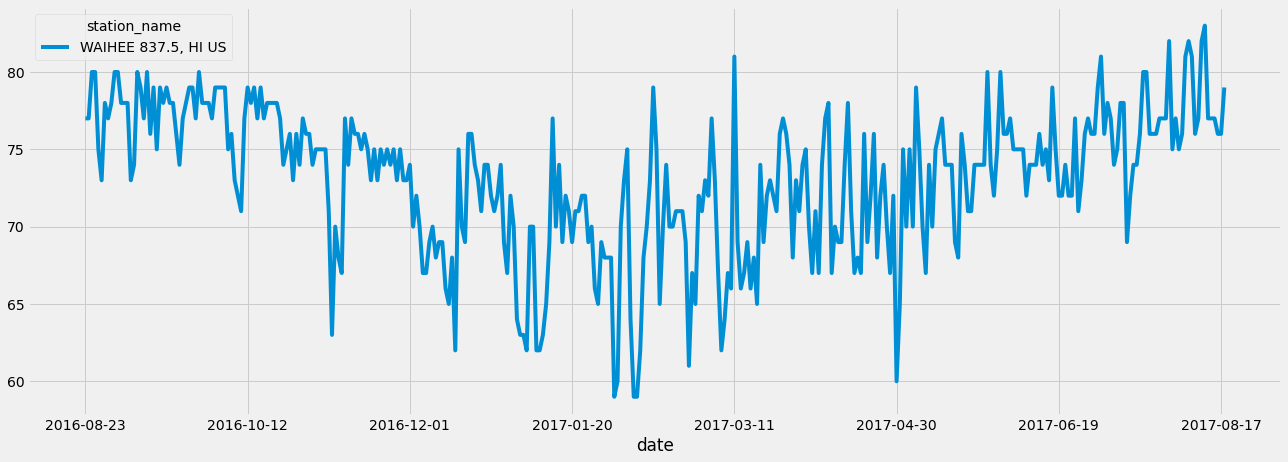

In [35]:
# Use Pandas Plotting with Matplotlib to plot the data
temp_obs_df_pvt.plot(figsize=(20,7))
plt.show()

In [36]:
# Close Session
session.close()

## Bonus Challenge Assignment

In [37]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
result = calc_temps('2012-02-28', '2012-03-05')
print(result)


[(62.0, 69.57142857142857, 74.0)]


In [38]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps(start_vacation, end_vacation))

[(62.0, 71.1086956521739, 82.0)]


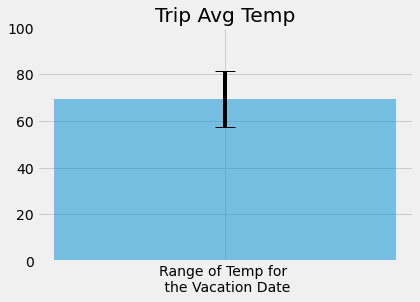

In [39]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_temp = result[0][1]
error = result[0][-1] - result[0][0]
fig, ax = plt.subplots()
ax.bar(
    x = 'Range of Temp for \n the Vacation Date', 
    height = avg_temp, 
    yerr = error,
    ecolor='black',
    align='center',
    alpha=0.5,
    capsize=10
    )
ax.set_title('Trip Avg Temp')
ax.set_ylim(0, 100)
ax.yaxis.grid(True)


In [40]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
total_rainfall = session.query(
    Measurement.station, 
    Station.name,
    Station.elevation,
    Station.latitude,
    Station.longitude,
    func.sum(Measurement.prcp),
    ).\
        group_by(Station.name).\
        filter(Measurement.station == Station.station).\
        filter(Measurement.date >= start_vacation).\
        filter(Measurement.date <= end_vacation).\
        order_by(func.sum(Measurement.prcp).desc()).\
        all()

In [41]:
# Store it to a Data Frame for better visualization
total_rainfall_df = pd.DataFrame(total_rainfall, columns=['station_id', 'station_name', 'elevation', 'lat', 'long', 'total_prcp'])
total_rainfall_df.head()

,station_id,station_name,elevation,lat,long,total_prcp
0,USC00513117,"KANEOHE 838.1, HI US",14.6,21.42340,-157.80150,5.76
1,USC00519281,"WAIHEE 837.5, HI US",32.9,21.45167,-157.84889,5.46
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",152.4,21.33310,-157.80250,3.50
3,USC00517948,"PEARL CITY, HI US",11.9,21.39340,-157.97510,3.04
4,USC00519397,"WAIKIKI 717.2, HI US",3.0,21.27160,-157.81680,2.74


In [42]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [43]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
normals=[]
start_vacation = dt.date(2017, 3, 1)
end_vacation = dt.date(2017, 3, 15)
# Use the start and end date to create a range of dates

vac_date = start_vacation
while vac_date <= end_vacation:
    data = f"{str(vac_date.month).zfill(2)}-{str(vac_date.day).zfill(2)}"
    normals.append(data)
    vac_date = vac_date + dt.timedelta(days=1)
# Loop through the list of %m-%d strings and calculate the normals for each date
list_normals = [daily_normals(x) for x in normals]
list_normals = [x[0]for x in list_normals]


In [44]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_normals_df = pd.DataFrame(list_normals, columns=['tmin', 'tavg', 'tmax'])
daily_normals_df['dates'] = normals
daily_normals_df.set_index('dates', drop=True, inplace=True)
daily_normals_df


,tmin,tavg,tmax
dates,,,
03-01,64.0,70.032787,76.0
03-02,61.0,70.366667,78.0
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0
03-06,60.0,69.203390,76.0
03-07,60.0,69.172414,78.0
03-08,59.0,68.724138,78.0
03-09,57.0,68.561404,75.0


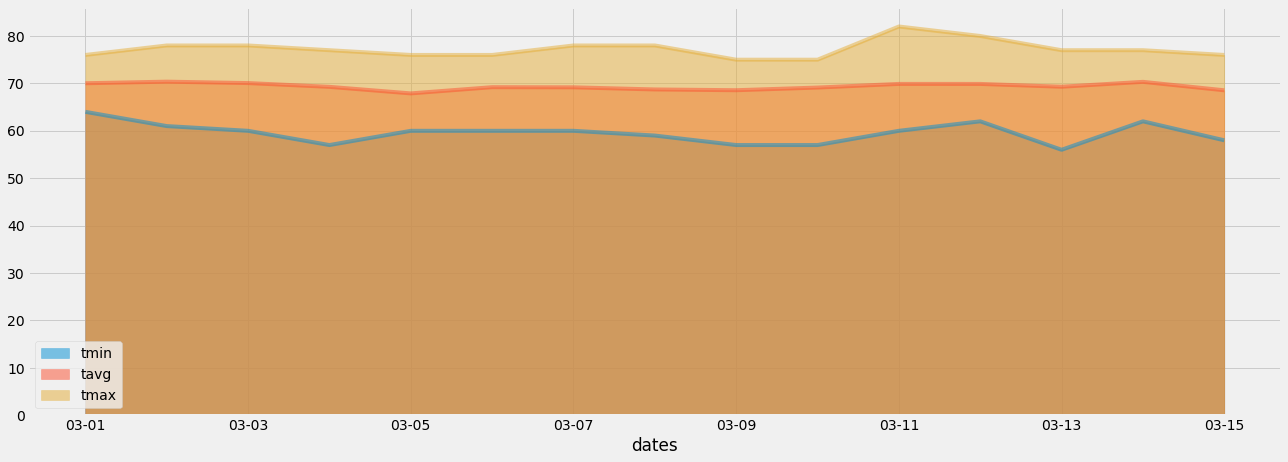

In [45]:
# Plot the daily normals as an area plot with `stacked=False`
daily_normals_df.plot.area(stacked=False, figsize=(20,7))
plt.show()

The end